In [1]:
from transformers import CLIPProcessor, CLIPModel
from datasets import load_dataset
import torch
import tqdm
import random

/usr/local/lib/python3.12/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
SAMPLE_SIZE = 12966 # Full dataset has 12966 samples

In [6]:
base_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").eval().to("cuda")
finetuned_model = CLIPModel.from_pretrained("../finetune_results/minifigure_finetune/clip-vit-base-patch32_lego-minifigure").eval().to("cuda")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

dataset = load_dataset("armaggheddon97/lego_minifigure_captions", split="train")
# get a subsample of the dataset randomly
dataset = dataset.shuffle(seed=42).select(range(SAMPLE_SIZE))

In [6]:
caption = dataset[0]["caption"]
image = dataset[0]["image"]
inputs = processor(text=caption, images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    base_output = base_model(**inputs.to("cuda"))
    finetuned_output = finetuned_model(**inputs)

In [7]:
print(base_output.keys())

odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])


In [8]:
# compare the text_embeds and image_embeds for both models
# to see how much the two embeddings differ
base_text_embeds = base_output["text_embeds"]
base_image_embeds = base_output["image_embeds"]

finetuned_text_embeds = finetuned_output["text_embeds"]
finetuned_image_embeds = finetuned_output["image_embeds"]

# use cosine similarity to compare the embeddings
base_similarity = torch.nn.functional.cosine_similarity(base_text_embeds, base_image_embeds)
finetuned_similarity = torch.nn.functional.cosine_similarity(finetuned_text_embeds, finetuned_image_embeds)

print(f"Base model similarity: {base_similarity}")
print(f"Finetuned model similarity: {finetuned_similarity}")

Base model similarity: tensor([0.4054], device='cuda:0')
Finetuned model similarity: tensor([0.4355], device='cuda:0')


In [9]:
# test the models on 100 samples a classification task
def eval_model(model, sample_size=100):
    correct = 0
    text_logits = []

    for i in tqdm.tqdm(range(sample_size)):
        random_indexes = random.sample(range(sample_size), 2)
        captions = [dataset[i]["caption"]]
        captions.extend([
            dataset[idx]["caption"]
            for idx in random_indexes
        ])
        image = dataset[i]["image"]

        inputs = processor(text=captions, images=image, return_tensors="pt", padding=True)
        with torch.no_grad():
            outputs = model(**inputs.to("cuda"))

        _text_logits = outputs["logits_per_text"]
        text_logits.append(_text_logits)
        probabilities = torch.nn.functional.softmax(_text_logits, dim=0)
        most_likely_class = torch.argmax(probabilities, dim=0)
        if most_likely_class == 0:
            correct += 1

    return {
        "accuracy": correct / sample_size,
        "text_logits": text_logits
    }

In [10]:
my_moedel_eval = eval_model(finetuned_model, sample_size=SAMPLE_SIZE)
base_model_eval = eval_model(base_model, sample_size=SAMPLE_SIZE)

print(f"Base model accuracy: {my_moedel_eval['accuracy']*100:.2f}")
print(f"Finetuned model accuracy: {base_model_eval['accuracy']*100:.2f}")

100%|██████████| 12966/12966 [07:34<00:00, 28.54it/s] 

Base model accuracy: 99.98
Finetuned model accuracy: 99.39


In [11]:
print("Base model: ", base_model_eval["text_logits"][0].flatten())
print("My model: ", my_moedel_eval["text_logits"][0].flatten())

Base model:  tensor([40.5435, 26.6920, 25.2377], device='cuda:0')
My model:  tensor([43.5745, 12.5075, 14.5690], device='cuda:0')


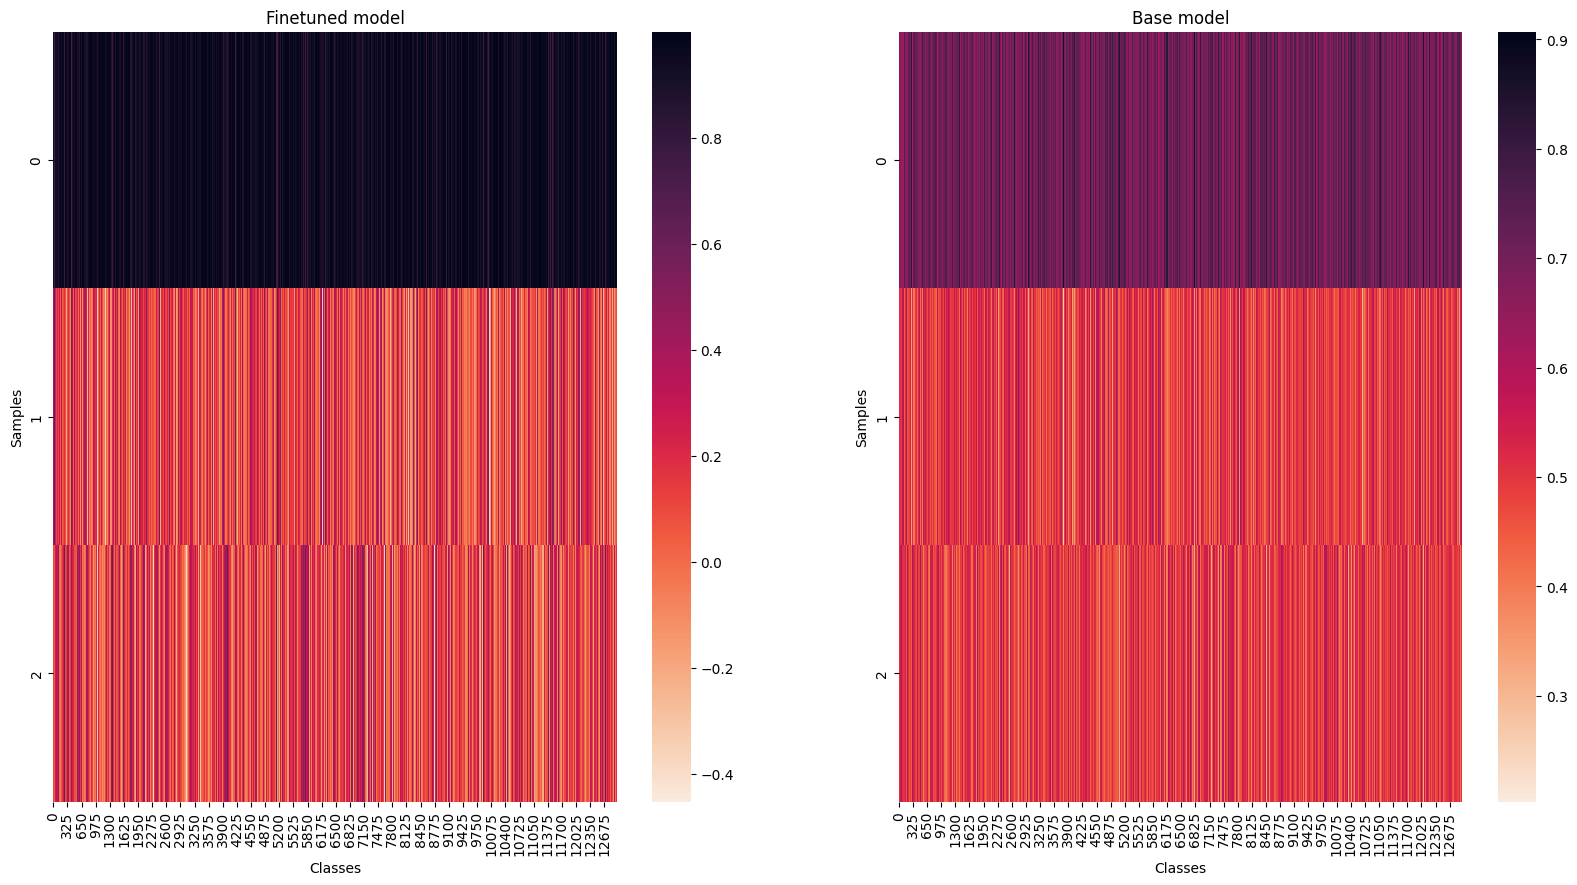

Base model:  tensor([0.7411, 0.4879, 0.4613], device='cuda:0')
Finetuned model:  tensor([0.9151, 0.2627, 0.3060], device='cuda:0')


In [12]:
# print a heatmap showing the logits for all the 100 samples evaluated
# for both models on the same plot, also add labels to the plot, and 
# normalize the logits to be between 0 and 1
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(20, 10))

finetuned_logits = torch.nn.functional.normalize(torch.cat(my_moedel_eval["text_logits"], dim=1), dim=0).cpu().numpy()
base_logits = torch.nn.functional.normalize(torch.cat(base_model_eval["text_logits"], dim=1), dim=0).cpu().numpy()

sns.heatmap(finetuned_logits, ax=ax[0], cmap="rocket_r")
ax[0].set_title("Finetuned model")
ax[0].set_xlabel("Classes")
ax[0].set_ylabel("Samples")

sns.heatmap(base_logits, ax=ax[1], cmap="rocket_r")
ax[1].set_title("Base model")
ax[1].set_xlabel("Classes")
ax[1].set_ylabel("Samples")

plt.show()
print("Base model: ", torch.nn.functional.normalize(base_model_eval["text_logits"][0], dim=0).flatten())
print("Finetuned model: ", torch.nn.functional.normalize(my_moedel_eval["text_logits"][0], dim=0).flatten())